# 05: Statistical Anomaly Detection 📈

This notebook implements the **Statistical Detection Layer** of the SalesOps Agent Suite. We use robust statistical methods (Z-Score, IQR) to identify significant deviations in sales patterns across global, regional, and category levels.

### 🎯 Goals
1.  **Load Data:** Import the cleaned sales snapshot.
2.  **Initialize Agent:** Load the `AnomalyStatAgent`.
3.  **Run Detectors:**
    * **Global Z-Score:** Detect major spikes/dips in total daily revenue.
    * **Grouped IQR:** Detect outliers within specific Regions and Categories (handling skewed B2B data).
4.  **Visualize:** Plot time-series with anomaly overlays to verify detection quality.
5.  **Export Payload:** Save the `anomaly_payload.json` containing context-rich anomaly records for the LLM Explainer Agent.

### 🏗️ Components Used
* `agents.anomaly_stats_agent.AnomalyStatAgent`: The core statistical engine using Z-Score and Inter-Quartile Range (IQR) logic.
* `pandas` / `matplotlib`: For data manipulation and visualization.

## 1) Imports

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from agents.anomaly_stats_agent import AnomalyStatAgent

print("✅ Anomaly Pipeline Loaded")

✅ Anomaly Pipeline Loaded


## 2) Load Data

In [3]:
# Load the features we built in Notebook 03 OR the clean snapshot
SNAPSHOT_PATH = "../data/processed/superstore_clean.parquet"

if not os.path.exists(SNAPSHOT_PATH):
    raise FileNotFoundError("Please run Notebook 01 or 04 to generate the snapshot.")

df = pd.read_parquet(SNAPSHOT_PATH)
print(f"Loaded {len(df)} rows.")
df.head(2)

Loaded 9994 rows.


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


## 3) Initialize & Run Detectors

In [4]:
agent = AnomalyStatAgent(df)

# 1. Global Sales Spike (Z-Score)
# High threshold (3.0) for major events
global_outliers = agent.detect_global_zscore(
    target_col="Sales", window=30, threshold=3.0
)

# 2. Regional Anomalies (IQR)
# Using IQR is better for Regions because some regions have volatile sales
agent.detect_grouped_iqr(group_col="Region", target_col="Sales", window=30, k=2.0)

# 3. Category Anomalies (IQR)
agent.detect_grouped_iqr(group_col="Category", target_col="Sales", window=30, k=2.0)

# Get consolidated list
anomalies_df = agent.get_anomalies_df()

print(f"Found {len(anomalies_df)} total anomalies.")
display(anomalies_df.head())

2025-11-22 08:41:49,614 - agents.anomaly_stats_agent - INFO - Running Global Z-Score Detector on Sales (w=30, t=3.0)
2025-11-22 08:41:49,624 - agents.anomaly_stats_agent - INFO - Running Grouped IQR Detector on Region (w=30, k=2.0)
2025-11-22 08:41:49,663 - agents.anomaly_stats_agent - INFO - Running Grouped IQR Detector on Category (w=30, k=2.0)


Found 358 total anomalies.


,anomaly_id,level,entity_id,period_start,period_end,metric,value,expected,score,detector,reason,context
0,zscore_Global_2014-03-17_s3,global,All_Regions,2014-03-17,2014-03-17,Sales,3960.358,626.66,3.62,zscore,Spike detected (Z=3.62),"{'window_mean': 626.66, 'window_std': 920.91, ..."
1,zscore_Global_2014-03-18_s5,global,All_Regions,2014-03-18,2014-03-18,Sales,28106.716,1560.31,5.21,zscore,Spike detected (Z=5.21),"{'window_mean': 1560.31, 'window_std': 5096.71..."
2,zscore_Global_2014-05-21_s3,global,All_Regions,2014-05-21,2014-05-21,Sales,4264.328,926.21,3.52,zscore,Spike detected (Z=3.52),"{'window_mean': 926.21, 'window_std': 949.24, ..."
3,zscore_Global_2014-06-01_s3,global,All_Regions,2014-06-01,2014-06-01,Sales,5188.520,996.18,3.44,zscore,Spike detected (Z=3.44),"{'window_mean': 996.18, 'window_std': 1219.37,..."
4,zscore_Global_2014-07-25_s4,global,All_Regions,2014-07-25,2014-07-25,Sales,8341.290,1287.73,4.26,zscore,Spike detected (Z=4.26),"{'window_mean': 1287.73, 'window_std': 1654.36..."


## 4) Visualization (Global)

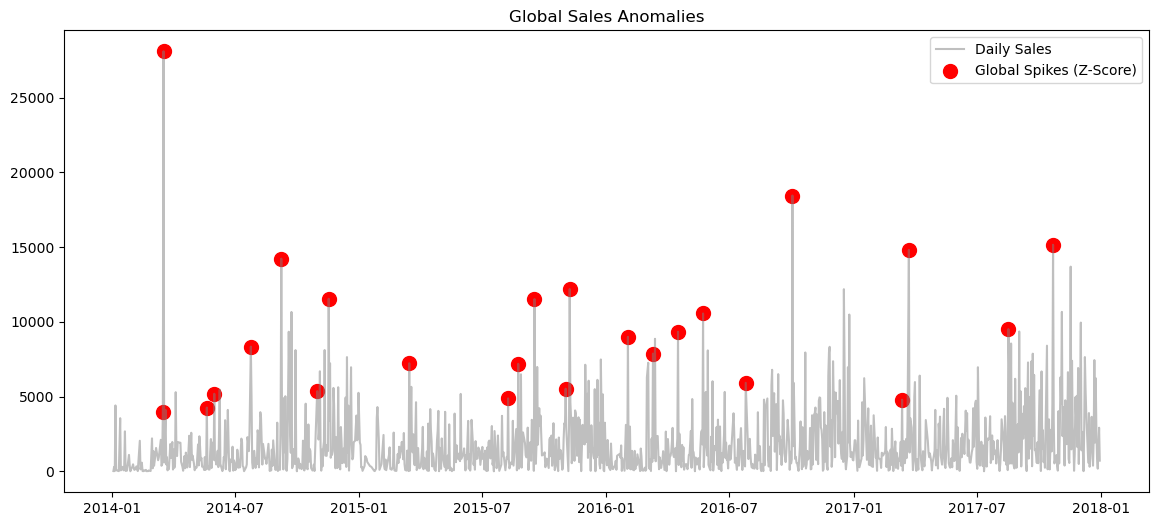

In [5]:
# Plot Global Sales
daily_sales = df.groupby("Order Date")["Sales"].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(
    daily_sales["Order Date"],
    daily_sales["Sales"],
    label="Daily Sales",
    color="grey",
    alpha=0.5,
)

# Overlay Global Z-Score Anomalies
global_anoms = anomalies_df[anomalies_df["detector"] == "zscore"]
plt.scatter(
    pd.to_datetime(global_anoms["period_start"]),
    global_anoms["value"],
    color="red",
    s=100,
    label="Global Spikes (Z-Score)",
)

plt.title("Global Sales Anomalies")
plt.legend()
plt.show()

## 5) Visualization (Regional Breakdown)

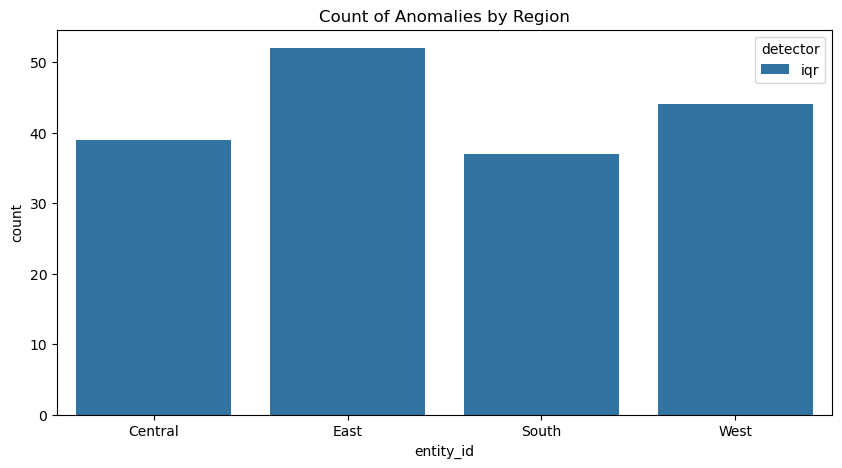

,anomaly_id,level,entity_id,period_start,period_end,metric,value,expected,score,detector,reason,context
130,iqr_South_2016-02-02_s21,region,South,2016-02-02,2016-02-02,Sales,8805.040,514.12,21.42,iqr,Outside Tukey Fence (Score=21.42),"{'Q1': 127.04, 'Q3': 514.12, 'IQR': 387.09}"
46,iqr_Central_2016-10-02_s19,region,Central,2016-10-02,2016-10-02,Sales,18336.740,1004.83,19.48,iqr,Outside Tukey Fence (Score=19.48),"{'Q1': 114.95, 'Q3': 1004.83, 'IQR': 889.88}"
115,iqr_South_2014-03-18_s17,region,South,2014-03-18,2014-03-18,Sales,23661.228,1438.84,17.41,iqr,Outside Tukey Fence (Score=17.41),"{'Q1': 162.29, 'Q3': 1438.84, 'IQR': 1276.56}"
72,iqr_East_2014-09-14_s15,region,East,2014-09-14,2014-09-14,Sales,4744.012,379.39,15.48,iqr,Outside Tukey Fence (Score=15.48),"{'Q1': 97.5, 'Q3': 379.39, 'IQR': 281.89}"
122,iqr_South_2015-03-16_s14,region,South,2015-03-16,2015-03-16,Sales,6911.700,482.46,14.08,iqr,Outside Tukey Fence (Score=14.08),"{'Q1': 25.92, 'Q3': 482.46, 'IQR': 456.54}"


In [6]:
# Filter for Region anomalies
region_anoms = anomalies_df[anomalies_df["level"] == "region"]

plt.figure(figsize=(10, 5))
sns.countplot(data=region_anoms, x="entity_id", hue="detector")
plt.title("Count of Anomalies by Region")
plt.show()

display(region_anoms.sort_values("score", ascending=False).head(5))

## 6) Save Payload

In [7]:
OUTPUT_JSON = "../outputs/anomalies/anomaly_payload.json"
agent.save_payload(OUTPUT_JSON)

print(f"✅ Payload saved to {OUTPUT_JSON}")

# Preview JSON structure
import json

with open(OUTPUT_JSON) as f:
    data = json.load(f)
    print(json.dumps(data["top_anomalies"][0], indent=2))

2025-11-22 08:42:12,800 - agents.anomaly_stats_agent - INFO - Saved 358 anomalies to ../outputs/anomalies/anomaly_payload.json


✅ Payload saved to ../outputs/anomalies/anomaly_payload.json
{
  "anomaly_id": "iqr_Technology_2014-03-18_s53",
  "level": "category",
  "entity_id": "Technology",
  "period_start": "2014-03-18",
  "period_end": "2014-03-18",
  "metric": "Sales",
  "value": 24739.748,
  "expected": 585.69,
  "score": 53.08,
  "detector": "iqr",
  "reason": "Outside Tukey Fence (Score=53.08)",
  "context": {
    "Q1": 130.64,
    "Q3": 585.69,
    "IQR": 455.05
  }
}


## 7) ⏭️ Next Step: Explaining the "Why" with AI

Success! We have successfully identified **"What"** happened.
* We detected global sales spikes.
* We found specific outliers in regions (e.g., 'West') and categories.
* We generated a structured JSON payload: `outputs/anomalies/anomaly_payload.json`.

However, knowing that "Sales dropped 40%" is only half the battle. A true SalesOps Assistant needs to explain **"Why"** it dropped.

In the next notebook, we will build the **Anomaly Explainer Agent**. This agent will:
1.  Read the anomaly records we just saved.
2.  Use **Gemini** to interpret the context (Z-scores, recent trends).
3.  Generate a natural language explanation for the sales manager.

👉 **Proceed to `notebooks/06_anomaly_explanation.ipynb`.**